In [1]:
%reload_kedro

2023-05-04 14:21:11,985 - kedro.extras.extensions.ipython - INFO - No path argument was provided. Using: /Users/gpalazzo/Desktop/dev/crypto_msc_thesis
2023-05-04 14:21:11,985 - kedro.extras.extensions.ipython - INFO - No path argument was provided. Using: /Users/gpalazzo/Desktop/dev/crypto_msc_thesis
2023-05-04 14:21:12,509 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2023-05-04 14:21:12,640 - kedro.extras.extensions.ipython - INFO - ** Kedro project crypto_thesis
2023-05-04 14:21:12,641 - kedro.extras.extensions.ipython - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from datetime import timedelta
import pandas as pd
from crypto_thesis.utils import build_log_return
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Base data

In [4]:
min_years_existence = catalog.load("params:min_years_existence")
end_date = catalog.load("params:raw_binance_get_data.end_date")

2023-05-04 14:21:13,856 - kedro.io.data_catalog - INFO - Loading data from `params:min_years_existence` (MemoryDataSet)...
2023-05-04 14:21:13,857 - kedro.io.data_catalog - INFO - Loading data from `params:raw_binance_get_data.end_date` (MemoryDataSet)...


In [5]:
df_prm = catalog.load("prm_binance")
df_prm.loc[:, "date"] = df_prm["open_time"].dt.date.apply(str)
df_prm = df_prm[["open_time", "date", "close", "symbol"]]
df_prm = df_prm.sort_values(by=["symbol", "open_time"])

2023-05-04 14:21:13,861 - kedro.io.data_catalog - INFO - Loading data from `prm_binance` (ParquetDataSet)...


In [6]:
df_prm_logret = df_prm.groupby("symbol").apply(build_log_return)
assert df_prm_logret["log_return"].isna().sum() == df_prm["symbol"].nunique()

In [7]:
end_date = pd.to_datetime(end_date)
cutoff_3y = str((end_date - timedelta(days = min_years_existence * 365)).date())
end_date = str(end_date.date())

In [8]:
df_prm_logret = df_prm_logret[df_prm_logret["date"] <= end_date]

In [9]:
df_prm_logret.head()

,open_time,date,close,symbol,shift,log_return
0,2018-04-17 04:00:00,2018-04-17,0.26709,ADAUSDT,NaN,NaN
1,2018-04-17 04:15:00,2018-04-17,0.26301,ADAUSDT,0.26709,-0.015394
2,2018-04-17 04:30:00,2018-04-17,0.26700,ADAUSDT,0.26301,0.015057
3,2018-04-17 04:45:00,2018-04-17,0.26664,ADAUSDT,0.26700,-0.001349
4,2018-04-17 05:00:00,2018-04-17,0.26966,ADAUSDT,0.26664,0.011262


### EDA: coins universe subset

In [10]:
df_prm_grp = df_prm_logret.groupby("symbol").agg({"date": ["min", "max"]}).reset_index()

In [11]:
df_prm_grp.columns = ["symbol", "date_min", "date_max"]

In [12]:
df_prm_grp = df_prm_grp.sort_values(by="date_min", ascending=True)

In [13]:
df_aux = df_prm_grp[(df_prm_grp["date_min"] >= cutoff_3y) | (df_prm_grp["date_max"] != end_date)]
symbols_to_delete = df_aux["symbol"].tolist()

In [14]:
df_prm_grp_drop = df_prm_grp.drop(df_aux.index)

In [15]:
print(f"Remaining symbols: {df_prm_grp_drop['symbol'].unique().tolist()}")
print(f"Remaining symbols number: {df_prm_grp_drop.shape[0]}")

Remaining symbols: ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'LTCUSDT', 'ADAUSDT', 'XRPUSDT', 'XLMUSDT', 'TRXUSDT', 'ETCUSDT', 'LINKUSDT', 'XMRUSDT', 'MATICUSDT', 'ATOMUSDT', 'DOGEUSDT', 'BUSDUSDT', 'BCHUSDT']
Remaining symbols number: 16


In [16]:
df_prm_grp_drop.head()

,symbol,date_min,date_max
4,BTCUSDT,2017-08-17,2023-01-31
8,ETHUSDT,2017-08-17,2023-01-31
3,BNBUSDT,2017-11-06,2023-01-31
10,LTCUSDT,2017-12-13,2023-01-31
0,ADAUSDT,2018-04-17,2023-01-31


In [17]:
# min and max values for Tron
df_prm[df_prm["symbol"] == "TRXUSDT"].agg({"close": ["min", "max"]})

,close
min,0.00711
max,0.17660


### EDA: cumulative log returns and percentage change

In [18]:
df_prm_dropped = df_prm[~df_prm["symbol"].isin(symbols_to_delete)]
assert df_prm_dropped.symbol.nunique() == 16

In [19]:
target_time_filter = df_prm_dropped.groupby("symbol")["open_time"].min().max()
df_prm_dropped = df_prm_dropped[df_prm_dropped["open_time"] >= target_time_filter]

assert df_prm_dropped.open_time.min() == target_time_filter

In [20]:
df_prm_logret = df_prm_dropped.groupby("symbol").apply(build_log_return)
assert df_prm_logret["log_return"].isna().sum() == df_prm_dropped["symbol"].nunique()

df_prm_logret.loc[:, "log_return"] = df_prm_logret["log_return"].fillna(0)
df_prm_logret.loc[:, "logret_cumsum"] = df_prm_logret.groupby("symbol")["log_return"].cumsum()

In [21]:
df_pivot = df_prm_logret.pivot(index="open_time", columns=["symbol"], values=["logret_cumsum"]) \
                            .dropna().sort_index()

In [22]:
# find negative and positive cumulative returns
df_aux = df_pivot["logret_cumsum"].copy().sort_index()
df_aux = df_aux.applymap(lambda row: np.exp(row) - 1)
df_tail = df_aux.tail(1)

df_tail_negative = df_tail[df_tail < 0]
df_logret_negative = pd.melt(df_tail_negative).dropna().rename(columns={"variable": "symbol", "value": "pctchg"})

print(df_logret_negative)
print()

df_tail_positive = df_tail[df_tail > 0]
df_logret_positive = pd.melt(df_tail_positive).dropna().rename(columns={"variable": "symbol", "value": "pctchg"})

print(df_logret_positive.sort_values(by="pctchg", ascending=False))

    symbol   pctchg
2  BCHUSDT -0.40084

       symbol     pctchg
11  MATICUSDT  42.574879
6    DOGEUSDT  37.486928
3     BNBUSDT  18.272475
8     ETHUSDT   9.373244
0     ADAUSDT   8.623865
7     ETCUSDT   4.397598
12    TRXUSDT   2.870243
1    ATOMUSDT   2.624518
14    XMRUSDT   2.181242
9    LINKUSDT   2.115183
4     BTCUSDT   2.046596
10    LTCUSDT   0.942417
15    XRPUSDT   0.740153
13    XLMUSDT   0.537668
5    BUSDUSDT   0.000300


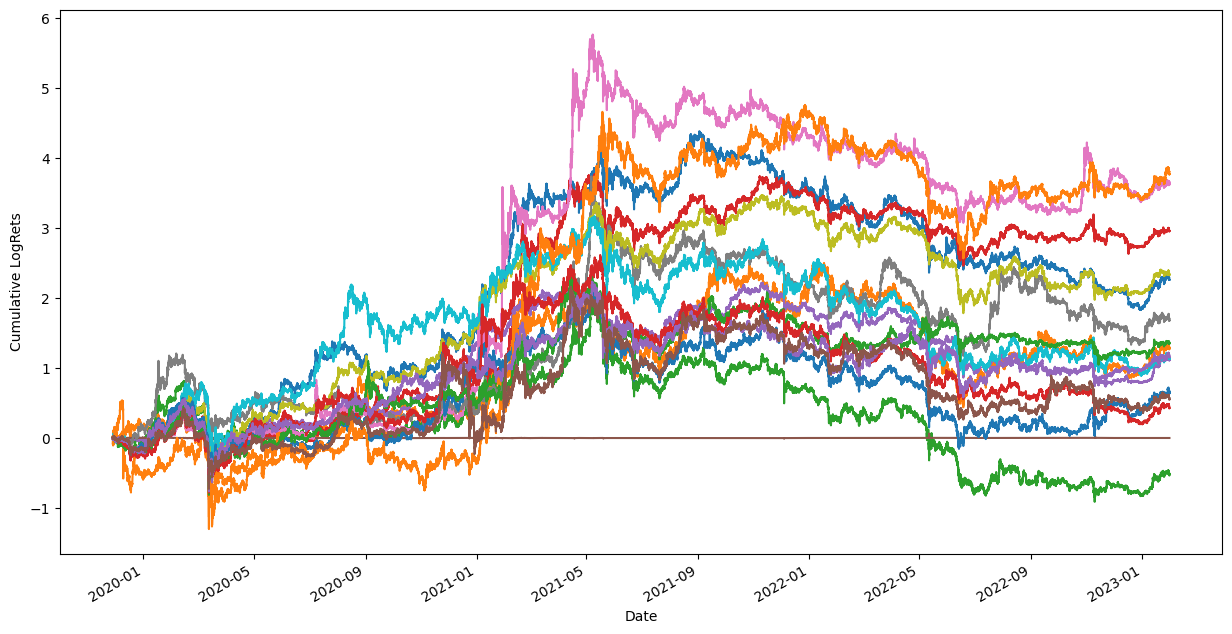

In [23]:
df_aux = df_pivot["logret_cumsum"].copy().sort_index()
plot = df_aux.plot(legend=None, figsize=(15, 8))
plot.set_xlabel("Date")
plot.set_ylabel("Cumulative LogRets")

fig = plot.get_figure()
fig.savefig("/Users/gpalazzo/Desktop/fig_cum_logrets_cryptos.png")

In [24]:
# ***** esse plot não ficou legal, manter o de log retornos *****

# df_aux = df_pivot["pctchg_cumsum"].copy()
# plot = df_aux.plot(legend=None, figsize=(15, 8))
# plot.set_xlabel("Date")
# plot.set_ylabel("Cumulative pctChg")

# fig = plot.get_figure()
# fig.savefig("/Users/gpalazzo/Desktop/fig_cum_pctchg_cryptos.png")

### EDA: log returns distribution

Building plot for: ADAUSDT
Building plot for: ATOMUSDT
Building plot for: BCHUSDT
Building plot for: BNBUSDT
Building plot for: BTCUSDT
Building plot for: BUSDUSDT
Building plot for: DOGEUSDT
Building plot for: ETCUSDT
Building plot for: ETHUSDT
Building plot for: LINKUSDT
Building plot for: LTCUSDT
Building plot for: MATICUSDT
Building plot for: TRXUSDT
Building plot for: XLMUSDT
Building plot for: XMRUSDT
Building plot for: XRPUSDT


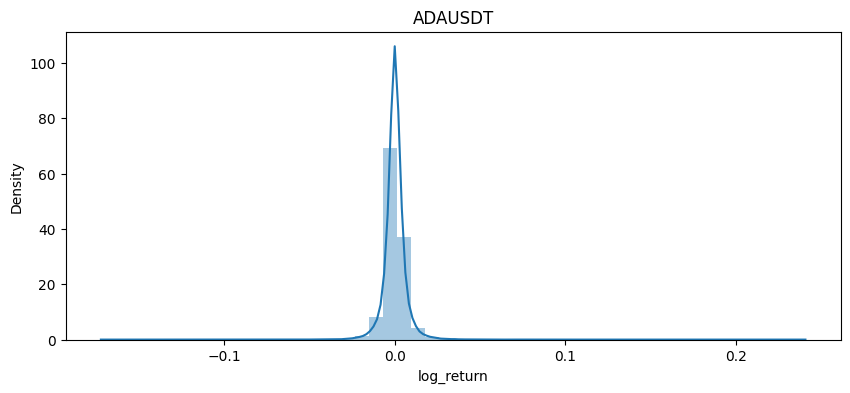

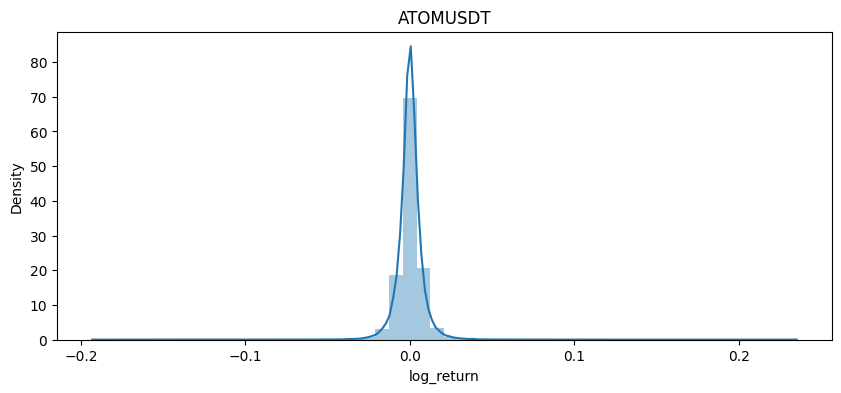

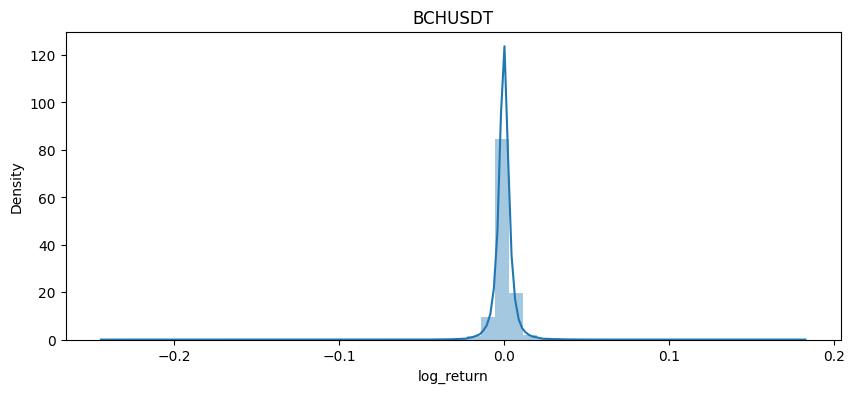

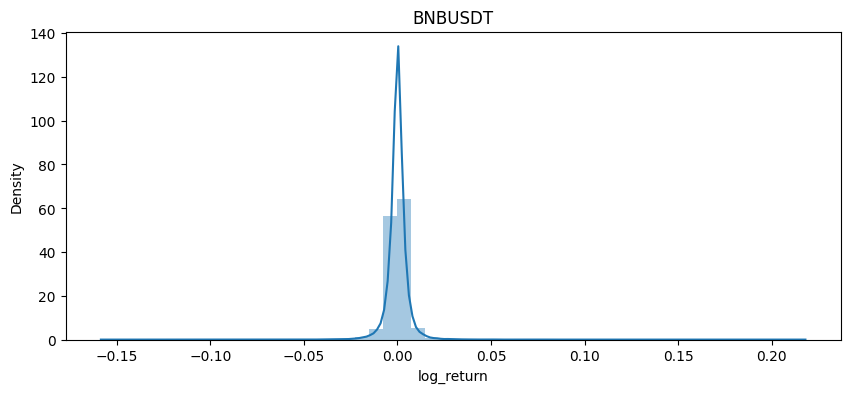

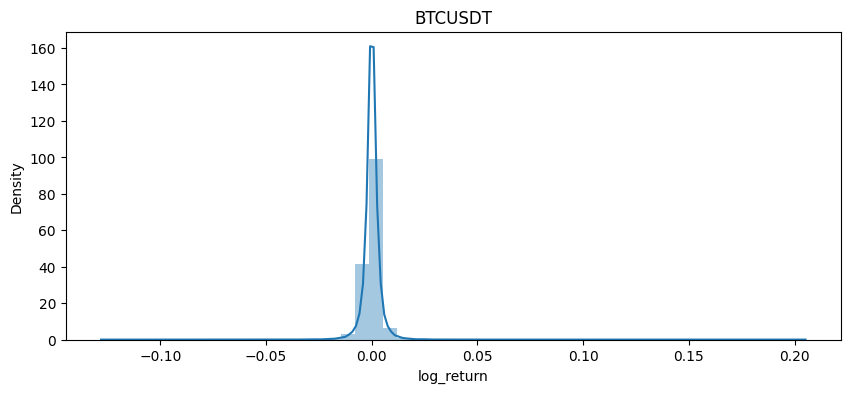

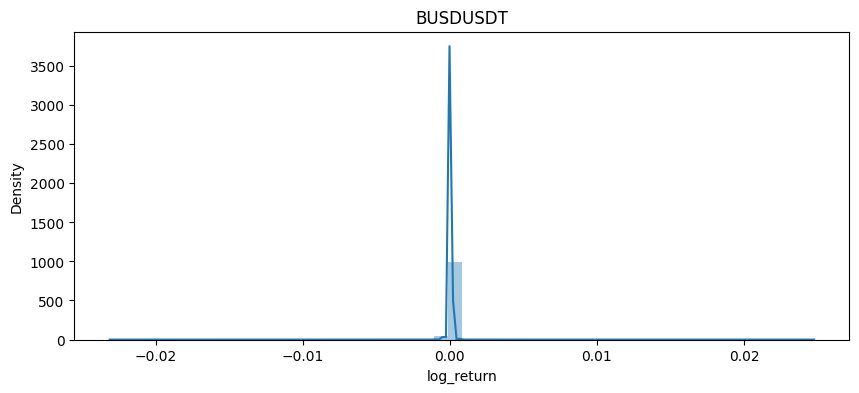

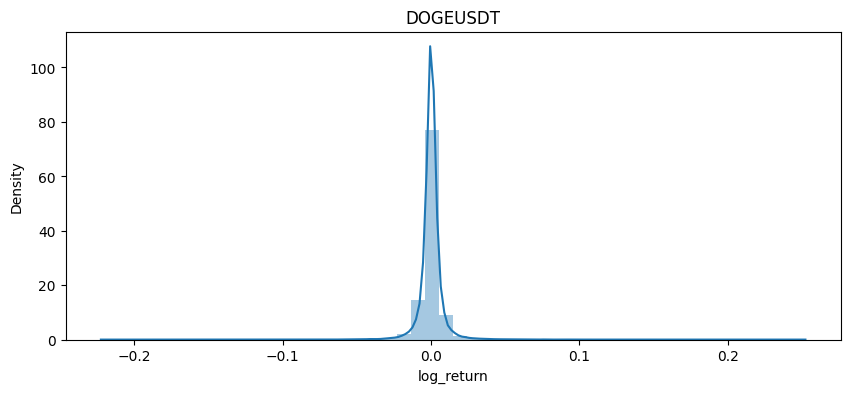

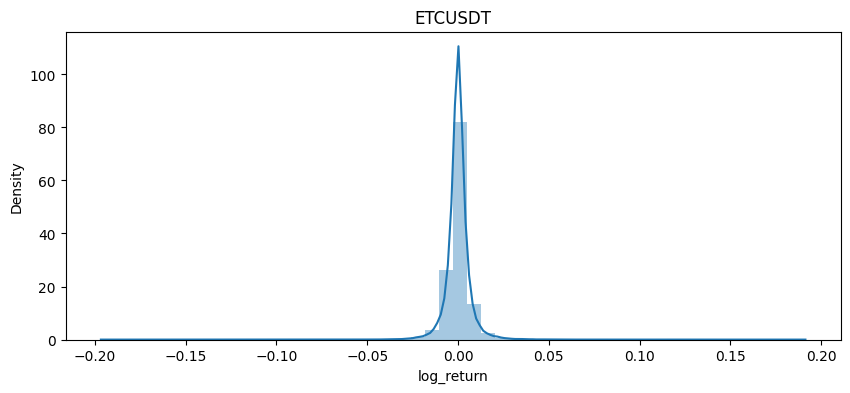

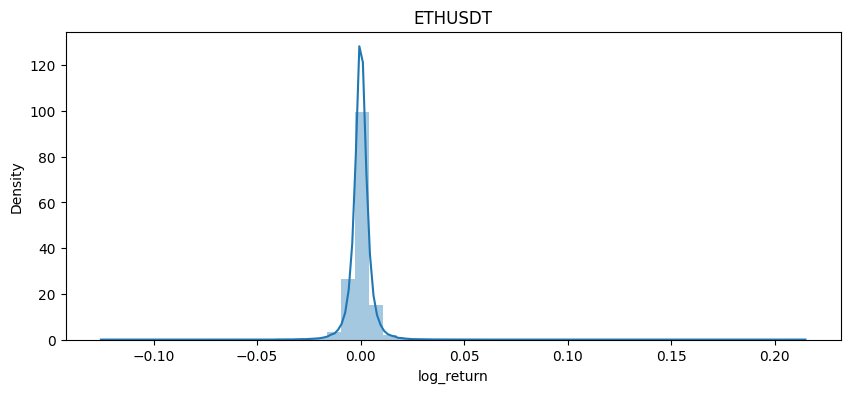

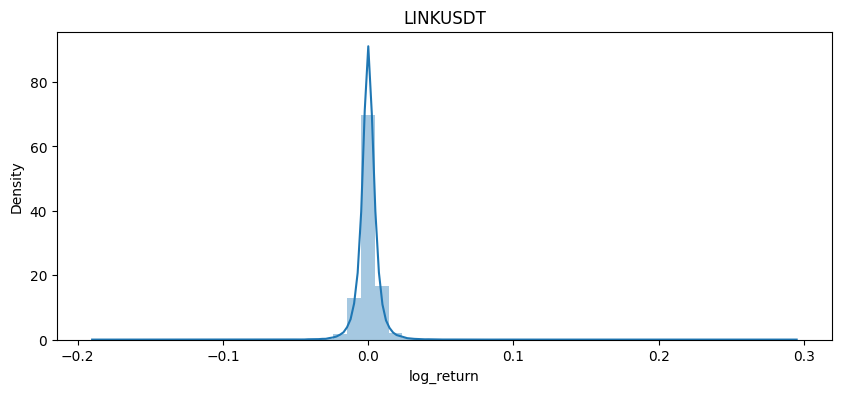

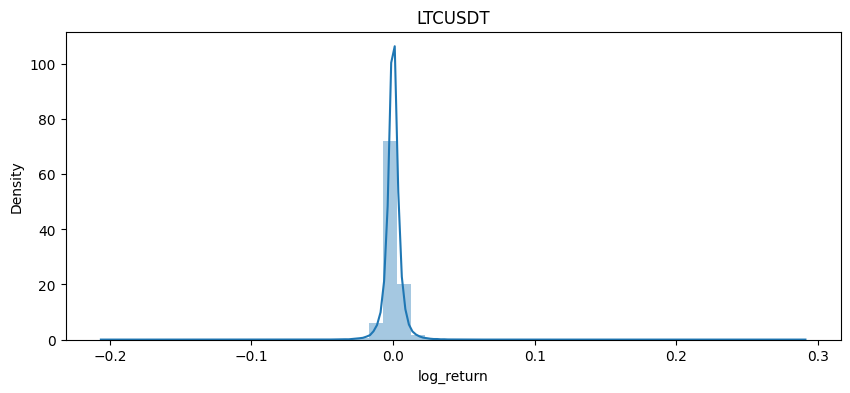

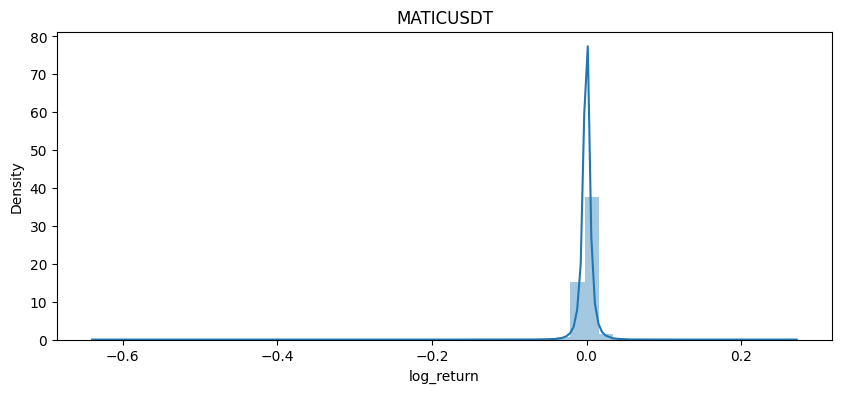

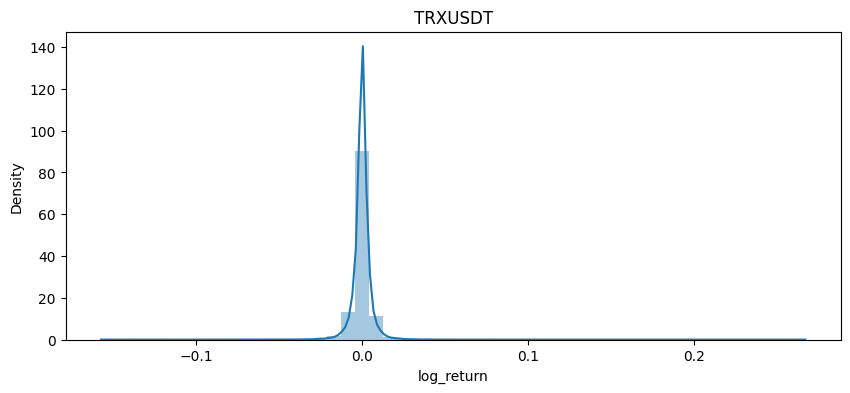

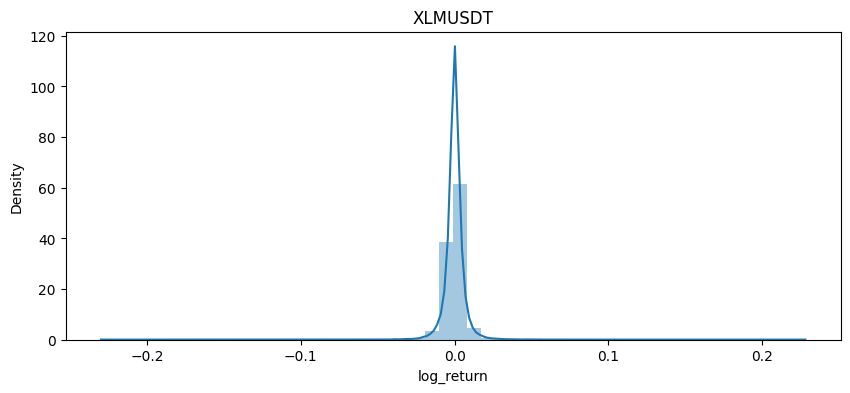

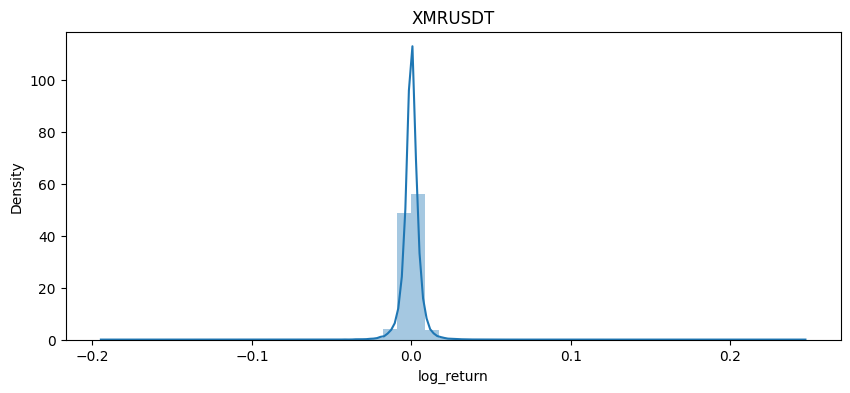

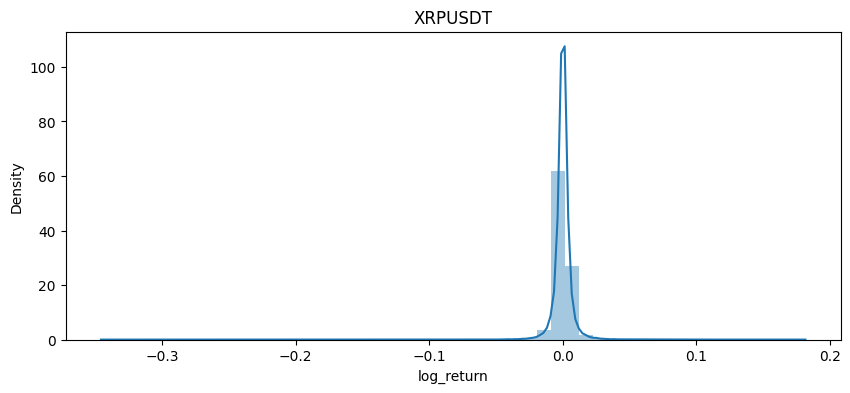

In [25]:
df_prm_dropped = df_prm_logret[~df_prm_logret["symbol"].isin(symbols_to_delete)]

for symbol in df_prm_dropped["symbol"].unique():

    print(f"Building plot for: {symbol}")
    
    df_aux = df_prm_dropped[df_prm_dropped["symbol"] == symbol][["open_time", "log_return"]]
    df_aux = df_aux.set_index("open_time").sort_index()
    
    plt.figure(figsize=(10,4))
    plt.title(symbol)
    sns.distplot(df_aux["log_return"])

### EDA: boxplot

In [26]:
df_prm_dropped = df_prm_logret[~df_prm_logret["symbol"].isin(symbols_to_delete)]

In [27]:
df_pivot = df_prm_dropped.pivot(index="open_time", columns=["symbol"], values=["log_return"]).dropna()
df_pivot = df_pivot.droplevel(level=0, axis=1)

symbols = df_pivot.columns.tolist()
df_pivot.columns = symbols

In [28]:
symbol_std_descending = df_pivot.std().reset_index().rename(columns={"index": "symbol", 0: "std"}) \
    .sort_values(by="std", ascending=False) \
    ["symbol"].tolist()

df_pivot = df_pivot[symbol_std_descending]

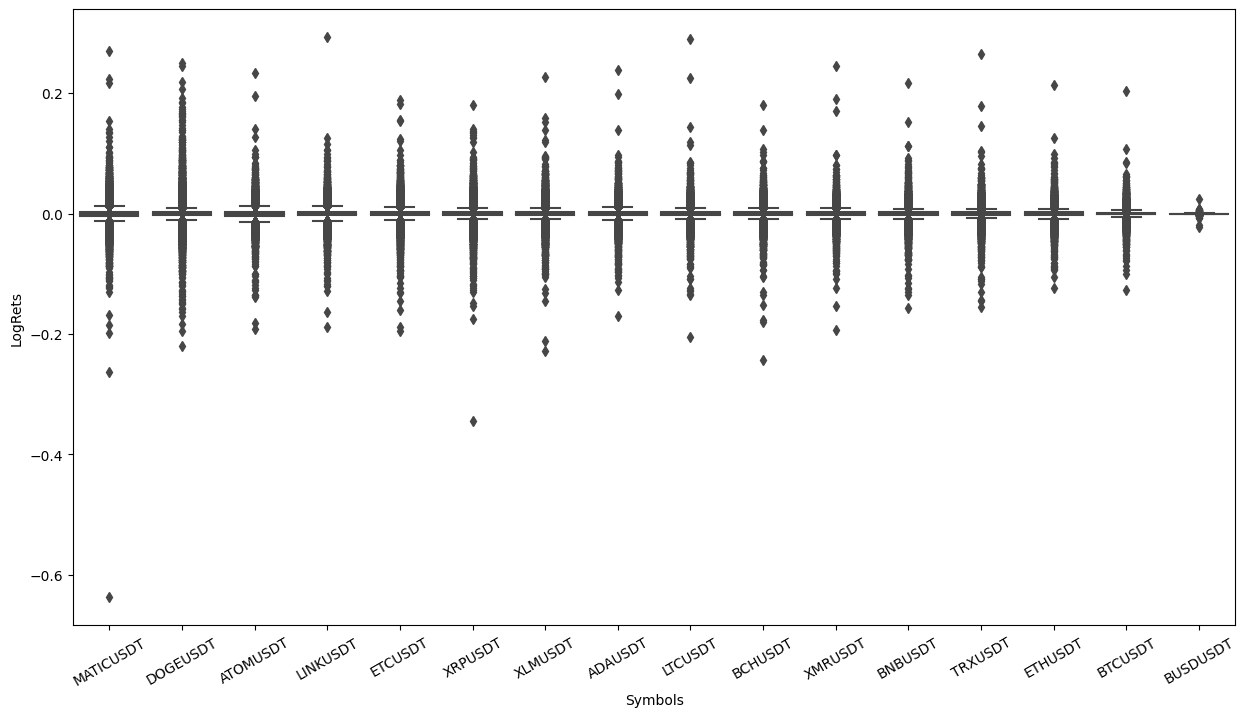

In [29]:
plt.figure(figsize=(15, 8))
plot = sns.boxplot(df_pivot)

plot.set_xlabel("Symbols")
plot.set_ylabel("LogRets")
plt.xticks(rotation = 30)

fig = plot.get_figure()
fig.savefig("/Users/gpalazzo/Desktop/fig_box_plot_cryptos.png")

### EDA: corr matrix

In [30]:
df_prm_dropped = df_prm_logret[~df_prm_logret["symbol"].isin(symbols_to_delete)]

df_pivot = df_prm_dropped.pivot(index="open_time", columns=["symbol"], values=["log_return"]).dropna()
df_pivot = df_pivot.droplevel(level=0, axis=1)

symbols = df_pivot.columns.tolist()
df_pivot.columns = symbols

In [31]:
corr_mtx = round(df_pivot.corr(), 2)
mask = np.triu(np.ones_like(corr_mtx, dtype=bool))

In [32]:
# find min and max correlation pairs
corr_mtx_parsed = corr_mtx[corr_mtx > 0].unstack().reset_index().dropna().rename(columns={0: "value"})
corr_mtx_parsed = corr_mtx_parsed[corr_mtx_parsed["value"] < 1]
corr_mtx_parsed.sort_values(by="value")

,level_0,level_1,value
182,MATICUSDT,DOGEUSDT,0.38
107,DOGEUSDT,MATICUSDT,0.38
198,TRXUSDT,DOGEUSDT,0.39
108,DOGEUSDT,TRXUSDT,0.39
111,DOGEUSDT,XRPUSDT,0.40
...,...,...,...
42,BCHUSDT,LTCUSDT,0.79
138,ETHUSDT,LTCUSDT,0.79
168,LTCUSDT,ETHUSDT,0.79
72,BTCUSDT,ETHUSDT,0.86


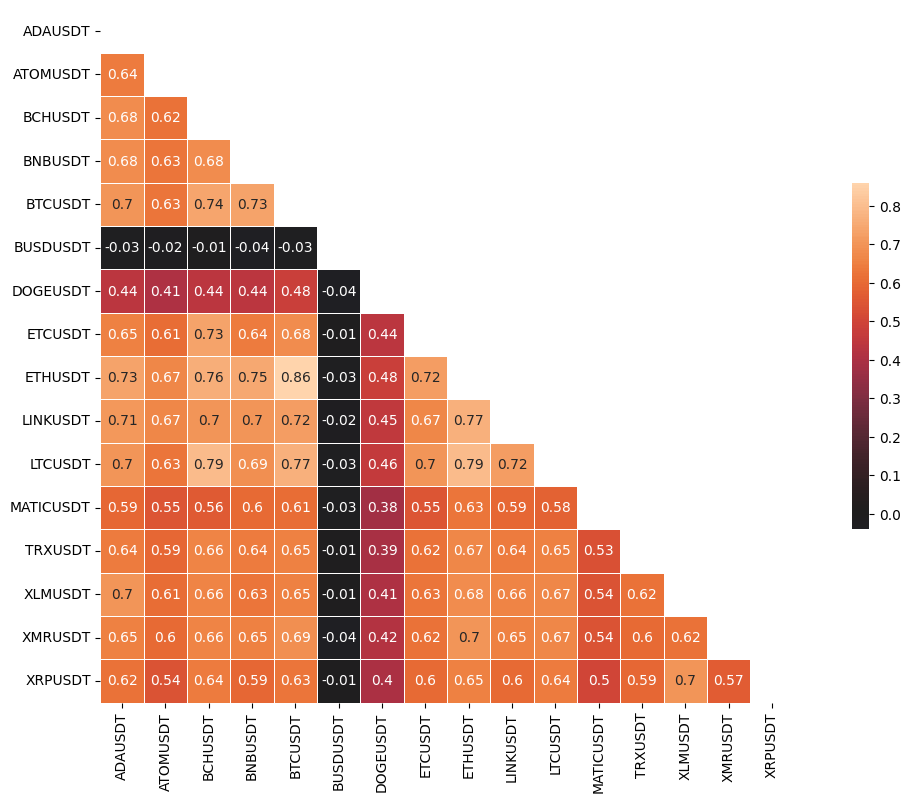

In [33]:
plt.figure(figsize=(15, 9))

plot = sns.heatmap(corr_mtx, 
                   annot=True, 
                   mask=mask, 
                   center=0,
                   square=True, 
                   linewidths=.5, 
                   cbar_kws={"shrink": .5}
                  )

fig = plot.get_figure()
fig.savefig("/Users/gpalazzo/Desktop/fig_corr_mtx_cryptos.png")

### EDA: captured variance

# REVISAR ESSA SEÇÃO PORQUE ESTÁ MEIO GAMBIARRA!

In [ ]:
df_prm_dropped = df_prm_logret[~df_prm_logret["symbol"].isin(symbols_to_delete)]
df_prm_dropped = df_prm_dropped.sort_values(by=["symbol", "open_time"])

In [ ]:
df_fte = catalog.load("fte_binance")
df_window_nbr = catalog.load("window_nbr_lookup_multic")

In [ ]:
# get lower window durations
df_fte_aux = df_fte.dropna()

df_fte_aux = df_fte_aux[df_fte_aux["window_duration_sec"] != 0.0]
_min_duration = df_fte_aux.window_duration_sec.min()
df_fte_aux = df_fte_aux[df_fte_aux["window_duration_sec"].between(_min_duration, _min_duration + 4500)]

In [ ]:
df_fte_window = df_fte_aux.merge(df_window_nbr[["open_time", "close_time", "window_nbr"]]\
                                 , on=["open_time", "close_time"], how="inner")

df_fte_window = df_fte_window[["open_time", "close_time", "window_nbr"] + \
                             [col for col in df_fte_window.columns if col \
                                  not in ["open_time", "close_time", "window_nbr"]
                             ]]

df_fte_window = df_fte_window[df_fte_window["window_nbr"].isin([1671, 1672, 1673, 1674, 1675])]

In [ ]:
possible_coins = list(set([col.split("__")[-1] \
     for col in df_fte_window.set_index(["open_time", "close_time", "window_nbr"]).columns \
     if col != "window_duration_sec"]))

possible_coins

In [ ]:
feature_example = "ATOMUSDT"

In [ ]:
df_fte_window[[col for col in df_fte_window.columns if col.endswith(feature_example)]].columns

In [ ]:
df_fte_aux = df_fte_window.reset_index(drop=True).tail(10) #get only the last window
df_fte_aux = df_fte_aux[
                        ["open_time", "close_time"] \
                        + [col for col in df_fte_aux.columns if col.endswith(feature_example)]
                       ]
df_fte_aux.head()

In [ ]:
df_prm_target = df_prm_dropped[df_prm_dropped["symbol"] == feature_example]

_open_time = df_fte_aux["open_time"].min()
_close_time = df_fte_aux["close_time"].max()

df_prm_target = df_prm_target[df_prm_target["open_time"].between(_open_time, _close_time)]
df_prm_target = df_prm_target[["open_time", "log_return"]]

df_prm_target.head()

In [ ]:
df_fte_aux = df_fte_aux.drop(columns=["open_time"])
df_prm_target = df_prm_target.rename(columns={"open_time": "close_time"})

final_df = df_prm_target.merge(df_fte_aux, on="close_time", how="left")

final_df.head()

In [ ]:
final_df = final_df.ffill().bfill()

In [ ]:
final_df.corr()["log_return"].sort_values(ascending=False)

In [ ]:
# zscore__ETHUSDT              0.457699
# zscore__XRPUSDT              0.184618
# log_return_std__LTCUSDT      0.183035
# zscore__ETHUSDT              0.179166
# zscore__ADAUSDT              0.167575